In [41]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from google.colab import drive
from keras import backend as K

import csv
import nltk
import string
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE

In [4]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pwd

/content


In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [7]:
path = '/content/drive/MyDrive/Colab Notebooks/ArticlesMarch2018.csv'

columns = []
rows = []
with open(path) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  columns = next(reader)
  for row in reader:
    rows.append(row)



In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/ArticlesMarch2018.csv'
df = pd.read_csv(path)
df.head()

,articleID,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,5a974697410cf7000162e8a4,By BINYAMIN APPELBAUM,article,"Virtual Coins, Real Resources","['Bitcoin (Currency)', 'Electric Light and Pow...",1,Business,1,2018-03-01 00:17:22,Economy,America has a productivity problem. One explan...,The New York Times,News,https://www.nytimes.com/2018/02/28/business/ec...,1207
1,5a974be7410cf7000162e8af,By HELENE COOPER and ERIC SCHMITT,article,U.S. Advances Military Plans for North Korea,"['United States Defense and Military Forces', ...",1,Washington,11,2018-03-01 00:40:01,Asia Pacific,The American military is looking at everything...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1215
2,5a9752a2410cf7000162e8ba,By THE EDITORIAL BOARD,article,Mr. Trump and the ‘Very Bad Judge’,"['Trump, Donald J', 'Curiel, Gonzalo P', 'Unit...",1,Editorial,26,2018-03-01 01:08:46,Unknown,Can you guess which man is the model public se...,The New York Times,Editorial,https://www.nytimes.com/2018/02/28/opinion/tru...,1043
3,5a975310410cf7000162e8bd,By JAVIER C. HERNÁNDEZ,article,"To Erase Dissent, China Bans Pooh Bear and ‘N’","['China', 'Xi Jinping', 'Term Limits (Politica...",1,Foreign,1,2018-03-01 01:10:35,Asia Pacific,Censors swung into action after Mr. Xi’s bid t...,The New York Times,News,https://www.nytimes.com/2018/02/28/world/asia/...,1315
4,5a975406410cf7000162e8c3,"By JESSE DRUCKER, KATE KELLY and BEN PROTESS",article,Loans Flowed to Kushner Cos. After Visits to t...,"['Kushner, Jared', 'Kushner Cos', 'United Stat...",1,Business,1,2018-03-01 01:14:41,Unknown,"Apollo, the private equity firm, and Citigroup...",The New York Times,News,https://www.nytimes.com/2018/02/28/business/ja...,1566


In [6]:
# Combining all the article snippets into one string
snippet = '\n'.join(df['snippet'])
print(type(snippet))
print(snippet)

<class 'str'>
America has a productivity problem. One explanation may be the growing use of real resources to make virtual products.
The American military is looking at everything from troop rotations to surveillance to casualty evacuations should it be ordered to take action against North Korea.
Can you guess which man is the model public servant?
Censors swung into action after Mr. Xi’s bid to become leader for life resurrected memories of Mao’s personality cult and the feverish emotions that it created.
Apollo, the private equity firm, and Citigroup made large loans last year to the family real estate business of Jared Kushner, President Trump’s senior adviser.
China has sent a top economic adviser to the United States to restore dialogue and quash a trade war. He faces long odds.
The president mixed facts and falsehoods while discussing gun policy and potential solutions with legislators.
Timothy Polin gives us choices.
Susan Wu, a Silicon Valley entrepreneur, has opened a school i

In [7]:
# applying lowercase for all capitalizations in order to reduce the corpus.
# splitting each snippet based on newline
corpus = snippet.lower().split('\n')
print(len(corpus)) # we have 1,385 snippets from articles

print(type(corpus))
print(corpus[:2])

1385
<class 'list'>
['america has a productivity problem. one explanation may be the growing use of real resources to make virtual products.', 'the american military is looking at everything from troop rotations to surveillance to casualty evacuations should it be ordered to take action against north korea.']


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_unique_words = len(tokenizer.word_index) + 1 # +1 b/c of OOV words
print(total_unique_words) # we have 6,862 unique words in the corpus plus one (1) for OOV
print(word_index)

6863
{'the': 1, 'a': 2, 'of': 3, 'to': 4, 'and': 5, 'in': 6, 'for': 7, 'is': 8, 'that': 9, 'on': 10, 'with': 11, 'an': 12, 'it': 13, 'has': 14, 'but': 15, 'new': 16, 'are': 17, 'as': 18, 'at': 19, 'his': 20, 'was': 21, 'president': 22, 'be': 23, 'from': 24, 'trump': 25, 'this': 26, 'about': 27, 'have': 28, 'what': 29, 'you': 30, 'he': 31, 'by': 32, 'who': 33, 'not': 34, 'more': 35, 'their': 36, '—': 37, 'can': 38, 'one': 39, '”': 40, 'its': 41, 'or': 42, 'they': 43, 'after': 44, 'will': 45, 'how': 46, 'do': 47, 'people': 48, 'her': 49, 'could': 50, 'said': 51, 'some': 52, 'into': 53, 'mr': 54, 'i': 55, 'out': 56, 'been': 57, 'house': 58, 'had': 59, 'your': 60, 'we': 61, 'than': 62, 'may': 63, 'like': 64, 'york': 65, 'years': 66, 'she': 67, 'would': 68, 'over': 69, 'up': 70, 'united': 71, 'times': 72, 'last': 73, 'most': 74, 'two': 75, 'all': 76, 'when': 77, 'time': 78, 'city': 79, 'now': 80, 'first': 81, 'year': 82, 'world': 83, 'so': 84, 'it’s': 85, 'our': 86, 'american': 87, 'other':

In [9]:
print(tokenizer.word_index['good'])
print(tokenizer.word_index['great'])

299
673


## Fetch the GloVe 100 dimensional word embeddings

In [10]:
# "https://nlp.stanford.edu/projects/glove/"
path = '/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt'
embeddings_index = {}
with open(path) as f:
  for line in f:
    values = line.split()
    word = values[0]
    coeffs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coeffs

# print out sample word embeddings
dict(list(embeddings_index.items())[0:2])

{',': array([-0.10767  ,  0.11053  ,  0.59812  , -0.54361  ,  0.67396  ,
         0.10663  ,  0.038867 ,  0.35481  ,  0.06351  , -0.094189 ,
         0.15786  , -0.81665  ,  0.14172  ,  0.21939  ,  0.58505  ,
        -0.52158  ,  0.22783  , -0.16642  , -0.68228  ,  0.3587   ,
         0.42568  ,  0.19021  ,  0.91963  ,  0.57555  ,  0.46185  ,
         0.42363  , -0.095399 , -0.42749  , -0.16567  , -0.056842 ,
        -0.29595  ,  0.26037  , -0.26606  , -0.070404 , -0.27662  ,
         0.15821  ,  0.69825  ,  0.43081  ,  0.27952  , -0.45437  ,
        -0.33801  , -0.58184  ,  0.22364  , -0.5778   , -0.26862  ,
        -0.20425  ,  0.56394  , -0.58524  , -0.14365  , -0.64218  ,
         0.0054697, -0.35248  ,  0.16162  ,  1.1796   , -0.47674  ,
        -2.7553   , -0.1321   , -0.047729 ,  1.0655   ,  1.1034   ,
        -0.2208   ,  0.18669  ,  0.13177  ,  0.15117  ,  0.7131   ,
        -0.35215  ,  0.91348  ,  0.61783  ,  0.70992  ,  0.23955  ,
        -0.14571  , -0.37859  , -0.045959 ,

In [11]:
# creating a matrix which will store our unique corpus words and their glove embeddings
embeddings_matrix = np.zeros((total_unique_words, 100))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [12]:
embeddings_matrix[1:3]

array([[-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
         0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
         0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
        -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
         0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
        -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
        -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
         0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
        -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
         0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
        -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
        -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
        -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
        -0.19358   , -0.074575  ,  0.23353   , -0.0

In [19]:
for line in corpus:
  seqs = tokenizer.texts_to_sequences([line])[0]
  print(seqs)

[193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797, 4, 105, 1646, 700]
[1, 87, 490, 8, 701, 19, 565, 24, 2798, 2799, 4, 1647, 4, 2800, 2801, 134, 13, 23, 1178, 4, 149, 273, 117, 159, 307]
[38, 30, 1648, 135, 168, 8, 1, 702, 160, 2802]
[2803, 1649, 53, 273, 44, 54, 2804, 1179, 4, 213, 161, 7, 136, 2805, 2806, 3, 2807, 1650, 2808, 5, 1, 2809, 1651, 9, 13, 1652]
[2810, 1, 566, 1653, 567, 5, 2811, 100, 902, 2812, 73, 82, 4, 1, 169, 158, 903, 345, 3, 2813, 1654, 22, 102, 568, 569]
[274, 14, 491, 2, 242, 308, 569, 4, 1, 71, 90, 4, 2814, 1655, 5, 2815, 2, 98, 118, 31, 570, 129, 1656]
[1, 22, 1657, 2816, 5, 1658, 130, 1659, 119, 243, 5, 1180, 1181, 11, 2817]
[2818, 2819, 571, 95, 1182]
[2820, 1660, 2, 904, 1183, 2821, 14, 1184, 2, 99, 6, 2822]
[1185, 32, 309, 2, 905, 2823, 5, 32, 1, 142, 1186, 31, 1661, 214, 1187, 703, 2824, 2, 704, 1188]
[29, 47, 30, 107, 26, 143, 8, 398]
[1, 2825, 906, 1189, 51, 1, 111, 705, 10, 1662, 195, 19, 2, 346, 1663, 137, 3, 572, 2826, 2827, 399, 573,

In [14]:
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)): 
    n_gram_seqs = token_list[:i+1] 
    input_sequences.append(n_gram_seqs)
print(len(input_sequences))
print(input_sequences)

26937
[[193, 14], [193, 14, 2], [193, 14, 2, 2796], [193, 14, 2, 2796, 699], [193, 14, 2, 2796, 699, 39], [193, 14, 2, 2796, 699, 39, 1177], [193, 14, 2, 2796, 699, 39, 1177, 63], [193, 14, 2, 2796, 699, 39, 1177, 63, 23], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797, 4], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797, 4, 105], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797, 4, 105, 1646], [193, 14, 2, 2796, 699, 39, 1177, 63, 23, 1, 397, 194, 3, 158, 2797, 4, 105, 1646, 700], [1, 87], [1, 87, 490], [1, 87, 490, 8], [1, 87, 490, 8, 701], [1, 87, 490, 8, 701, 19], [1, 87, 490, 8, 701

In [15]:
len(input_sequences) # we have almost 27,000 n_grams

26937

In [16]:
# the length of the largest sequence this will be the input_length for our model
max_seq_length = max([len(x) for x in input_sequences])

# padded input_sequences of tokens for each line
input_seqs = np.array(pad_sequences(input_sequences, maxlen=max_seq_length, padding='pre'))
print(max_seq_length)
print(input_seqs[:5])

41
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0  193   14]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  193   14    2]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0  193   14    2 2796]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  193   14    2 2796  699]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     

In [17]:
# creating X-values and y-values
x_values, labels = input_seqs[:, :-1], input_seqs[:, -1]
y_values = tf.keras.utils.to_categorical(labels, num_classes=total_unique_words)

In [18]:
print(x_values[:3])
print(labels[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0 193]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 193  14]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 193  14   2]]
[  14    2 2796]


In [20]:
total_unique_words, max_seq_length

(6863, 41)

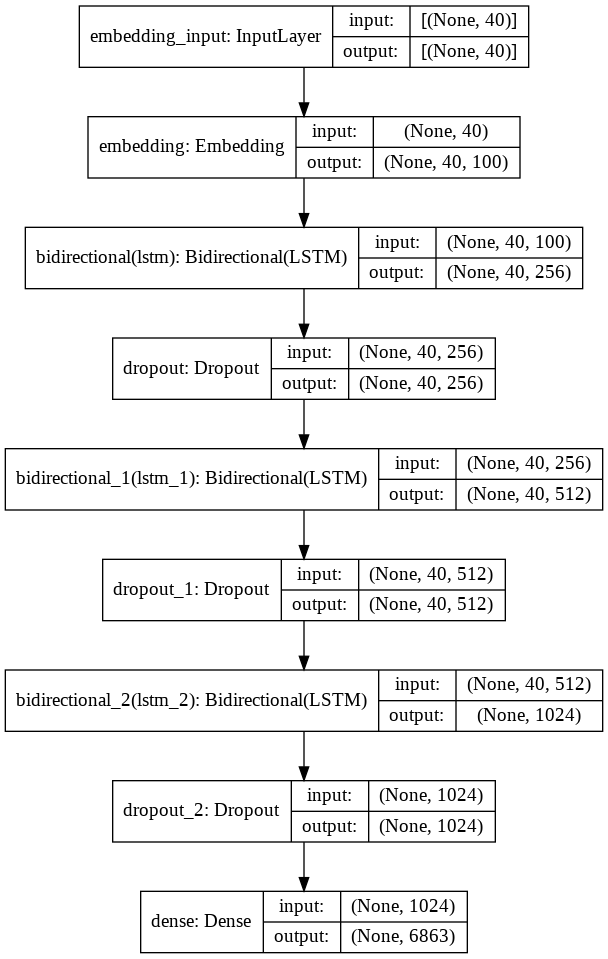

In [91]:
K.clear_session()

'''
callbacks = [EarlyStopping(monitor='val_accuracy', mode='max', patience=7),
             ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/nlp_word_prediction/modelmodel.h5', save_best_only=True, 
                             save_weights_only=False)]
'''

model = tf.keras.Sequential([
                             # input_dim: the total num of unique words which need embeddings
                             # input_length: the largest size of sequences 
                             # output_dim is 100 as we are using GloVe_100 dimensions
                             tf.keras.layers.Embedding(input_dim = total_unique_words, output_dim=100, 
                                                       # subtract one b/c the last word is what we are predicting
                                                       
                                                       weights=[embeddings_matrix],
                                                       input_length=max_seq_length-1,
                                                       trainable=False),
                             # using a bidirectional LSTM we wouldnt get a much repeating words
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
                             tf.keras.layers.Dropout(0.5),
                             # this is our last layer so we are predicting all the words for all one-hot encoding
                             # we could have also used y_values.shape[1] as the input for the dense layer
                             tf.keras.layers.Dense(total_unique_words , activation='softmax')])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)


In [92]:
history = model.fit(x_values, y_values, epochs=120, validation_split=0.2, verbose=1, batch_size=128)

Epoch 1/120
169/169 [==============================] - 17s 63ms/step - loss: 7.4547 - accuracy: 0.0491 - val_loss: 7.4136 - val_accuracy: 0.0496
Epoch 2/120
169/169 [==============================] - 8s 47ms/step - loss: 7.1401 - accuracy: 0.0514 - val_loss: 7.4470 - val_accuracy: 0.0525
Epoch 3/120
169/169 [==============================] - 8s 47ms/step - loss: 7.0312 - accuracy: 0.0562 - val_loss: 7.4722 - val_accuracy: 0.0646
Epoch 4/120
169/169 [==============================] - 8s 47ms/step - loss: 6.9180 - accuracy: 0.0667 - val_loss: 7.4739 - val_accuracy: 0.0713
Epoch 5/120
169/169 [==============================] - 8s 47ms/step - loss: 6.8065 - accuracy: 0.0717 - val_loss: 7.4904 - val_accuracy: 0.0781
Epoch 6/120
169/169 [==============================] - 8s 47ms/step - loss: 6.7100 - accuracy: 0.0745 - val_loss: 7.5034 - val_accuracy: 0.0830
Epoch 7/120
169/169 [==============================] - 8s 47ms/step - loss: 6.5946 - accuracy: 0.0796 - val_loss: 7.5567 - val_accuracy

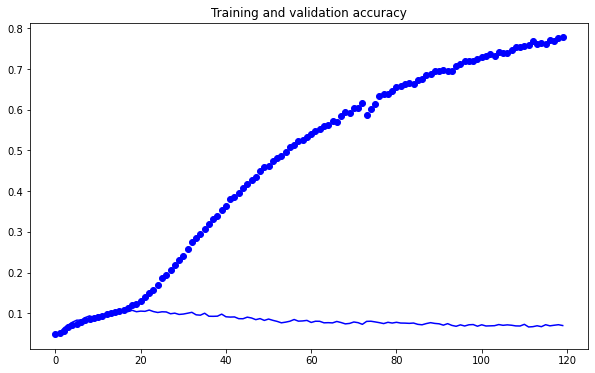

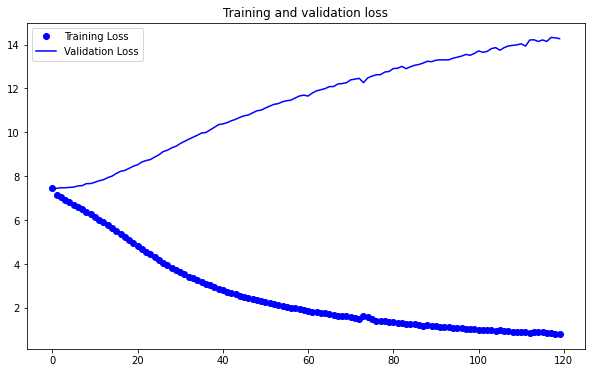

In [107]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure(figsize=(10,6))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [93]:
def prediction(seed_text, next_words):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_seq_length-1, padding='pre')
  #This will give us the token of the word most likely to be the next one in the sequence
    predicted = np.argmax(model.predict(token_list, verbose=1), axis=-1)

    ouput_word = ""
  # otkenizer.word_index.items() produces the word/index for training words
    for word, index in tokenizer.word_index.items():
    # predicted output is the token/index 
      if index == predicted:
        output_word = word
        break
    seed_text += ' '+output_word
    print(seed_text)

In [109]:
seed_text1 = "I truly enjoy riding my motorcycle"
next_words1 = len('can be an overlooked group. Some have grown more vocal marching and testifying in favor of limits'.split())

prediction(seed_text1, 10)

1/1 [==============================] - 0s 22ms/step
I truly enjoy riding my motorcycle list
1/1 [==============================] - 0s 21ms/step
I truly enjoy riding my motorcycle list yet
1/1 [==============================] - 0s 24ms/step
I truly enjoy riding my motorcycle list yet ”
1/1 [==============================] - 0s 22ms/step
I truly enjoy riding my motorcycle list yet ” everyone
1/1 [==============================] - 0s 24ms/step
I truly enjoy riding my motorcycle list yet ” everyone asks
1/1 [==============================] - 0s 23ms/step
I truly enjoy riding my motorcycle list yet ” everyone asks i
1/1 [==============================] - 0s 25ms/step
I truly enjoy riding my motorcycle list yet ” everyone asks i hate
1/1 [==============================] - 0s 28ms/step
I truly enjoy riding my motorcycle list yet ” everyone asks i hate this
1/1 [==============================] - 0s 23ms/step
I truly enjoy riding my motorcycle list yet ” everyone asks i hate this question
1/1 [